In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart_2022_cleaned.csv


In [2]:
import pandas as pd

import numpy as np

from scipy.stats import chi2,norm

import warnings

import os

import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns

In [3]:
PATH="/kaggle/input/heart_2022_cleaned.csv"
# PATH="dataset/heart_2022_cleaned.csv"

In [4]:
warnings.filterwarnings("ignore")

In [5]:
def stratified_sampling(df, column_name, num_samples):

    return df.groupby(column_name, group_keys=False).apply(lambda x: x.sample(n = num_samples, replace=False))

In [6]:
def random_sampling(df, num_samples):

    return df.sample(n = num_samples, replace=False)

In [7]:
data = pd.read_csv(PATH)

In [8]:
def do_chi2_test(data,column1,column2,alpha = 0.01):

    # print("***************************************************************************************************************************")

    # print("Chi2 Test for ",column1 ," and " ,column2)

    observed={}

    cols=data[column1].unique()

    for i in range(len(data[column2])):

        if data[column2].iloc[i] not in observed:

            observed[data[column2].iloc[i]]={}

            for j in cols:

                observed[data[column2].iloc[i]][j]=0

        observed[data[column2].iloc[i]][data[column1].iloc[i]]+=1



    observed=pd.DataFrame(observed).T

    observed=observed.sort_index()

    observed=observed[sorted(observed.columns)]

    # print("Observed")

    # print(observed)

    # print()

    observed=observed.to_numpy()

    row_sums = observed.sum(axis=1)

    col_sums = observed.sum(axis=0)

    total = row_sums.sum()

    # expected = np.outer(row_sums, col_sums) / total



    expected=np.zeros(observed.shape)

    for i in range(observed.shape[0]):

        for j in range(observed.shape[1]):

            expected[i][j]=row_sums[i]*col_sums[j]/total

    exp=pd.DataFrame(expected)

    exp.columns=sorted(data[column1].unique())

    exp.index=sorted(data[column2].unique())

    # print("Expected") 

    # print(exp)

    chi2_stat = ((observed - expected)**2 / expected).sum()

   

    dof=(len(row_sums)-1)*(len(col_sums)-1)

    critical = chi2.ppf(1-alpha, dof)

    # print("chi2_stat: ",chi2_stat)

    # print("critical: ",critical)

    if chi2_stat>=critical:

        # print("Dependent (reject H0)")

        return [chi2_stat,critical,1]

    else:

        # print("Independent (fail to reject H0)")

        return [chi2_stat,critical,-1]

In [9]:
categorical_columns = data.select_dtypes(include=['object']).columns

categorical_columns

Index(['State', 'Sex', 'GeneralHealth', 'LastCheckupTime',
       'PhysicalActivities', 'RemovedTeeth', 'HadHeartAttack', 'HadAngina',
       'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
       'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory',
       'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver',
       'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos'],
      dtype='object')

### $\chi^2$ Test for independence  ###

In [10]:
def create_files(sampling_type,range_lower,range_upper,step):

    for col in categorical_columns:

        if col=='GeneralHealth':

            continue

        for num_samples in range(range_lower,range_upper,step):

            os.makedirs(f'/kaggle/working/output/{sampling_type}/{range_lower}_to_{range_upper}/{num_samples}', exist_ok=True)

            f=open(f"output/{sampling_type}/{range_lower}_to_{range_upper}/{num_samples}/{col}.txt","w")

            for iteration in range(1,6):

                if sampling_type=="stratified_sampling":

                    sample = stratified_sampling(data,'GeneralHealth',num_samples)

                else:

                    sample = random_sampling(data,num_samples)

                f.write(f"<Iteration-{iteration}>\n")

                chi2_stat,chi2_critical,result = do_chi2_test(sample,col,'GeneralHealth',0.01)

                f.write(f"{chi2_stat}\n")

                f.write(f"{chi2_critical}\n")

                f.write(f"{result}\n")

                print(f"Iteration-{iteration} done")

            print(f"Sample Size-{num_samples} done")    

            f.close()

        print(f"{col} done")

In [11]:
def make_experiment_plots(sampling_technique,lower_bound,upper_bound,step_size):
    fig, axes = plt.subplots(len(categorical_columns), 1, figsize=(10, 100))

    for i,categorical_feature in enumerate(categorical_columns):
    
        if categorical_feature=='GeneralHealth':continue
    
        feature_output = []
    
        for num_samples in range(lower_bound,upper_bound,step_size):
    
            with open(f"output/{sampling_technique}/{lower_bound}_to_{upper_bound}/{num_samples}/{categorical_feature}.txt", "r") as f:
    
                lines = f.readlines()
    
            every_4th_line = [float(lines[j].strip().split()[0]) for j in range(3, len(lines), 4)]
    
            feature_output.append(sum(every_4th_line))
    
        data = pd.DataFrame({'Num Samples': range(lower_bound,upper_bound,step_size), 'Test Result': feature_output})
    
        sns.barplot(ax=axes[i],x="Num Samples",y="Test Result", data = data)
    
        axes[i].set_yticks(range(-5,6))
    
        axes[i].axhline(0,color='black',linewidth=0.5)
    
        axes[i].set_title(f"{categorical_feature} vs Num Samples")
    
    plt.tight_layout()
    plt.savefig(f"{sampling_technique}_{lower_bound}_to_{upper_bound}.png")
    


### Stratified Sampling ###

### Sample Size : 1000 to 10000

In [12]:
create_files('stratified_sampling',1000,10001,1000)

Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-1000 done
Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-2000 done
Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-3000 done
Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-4000 done
Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-5000 done
Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-6000 done
Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-7000 done
Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-8000 done
Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-9000 done
Iteration-1 done
Iteration-2 done
Ite

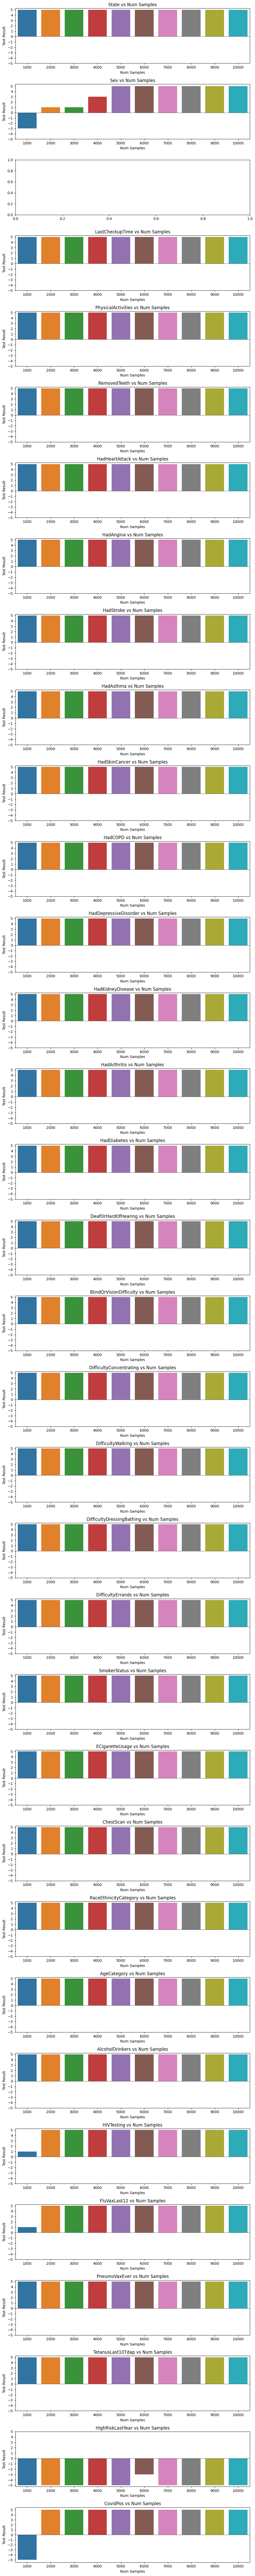

In [13]:
make_experiment_plots("stratified_sampling",1000,10001,1000)

### Sample Size : 100 to 1000 ###

In [14]:
create_files('stratified_sampling',100,1001,100)

Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-100 done
Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-200 done
Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-300 done
Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-400 done
Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-500 done
Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-600 done
Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-700 done
Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-800 done
Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-900 done
Iteration-1 done
Iteration-2 done
Iteration-3 

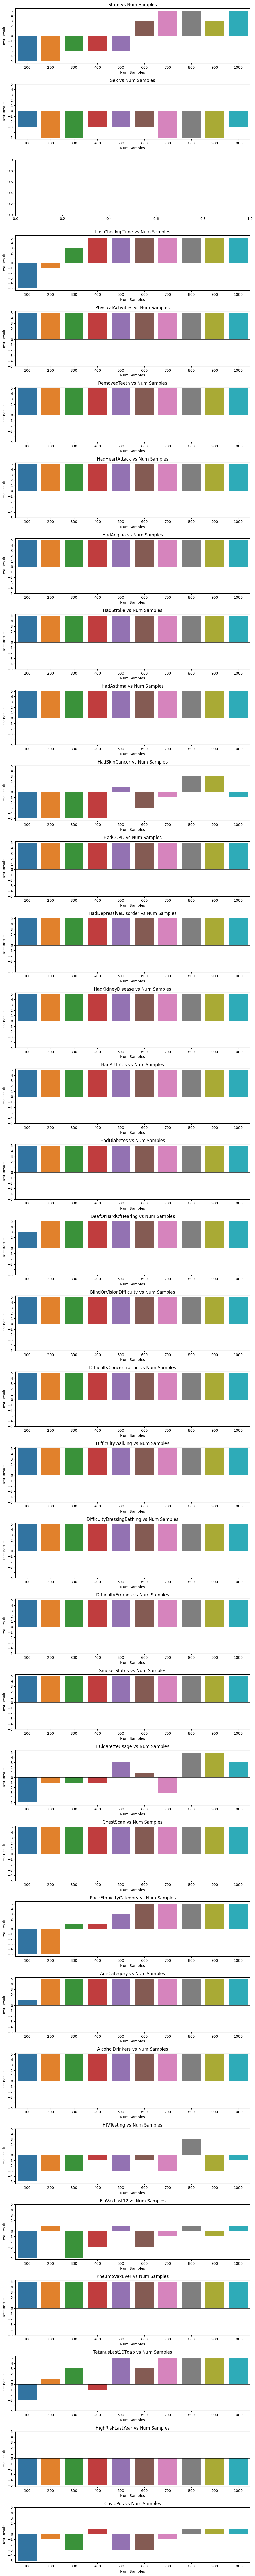

In [15]:
make_experiment_plots("stratified_sampling",100,1001,100)

### Random Sampling ###

### Sample Size : 5000 to 50000 ###

In [16]:
create_files("random_sampling",5000,50001,5000)

Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-5000 done
Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-10000 done
Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-15000 done
Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-20000 done
Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-25000 done
Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-30000 done
Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-35000 done
Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-40000 done
Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-45000 done
Iteration-1 done
Iteration-2 

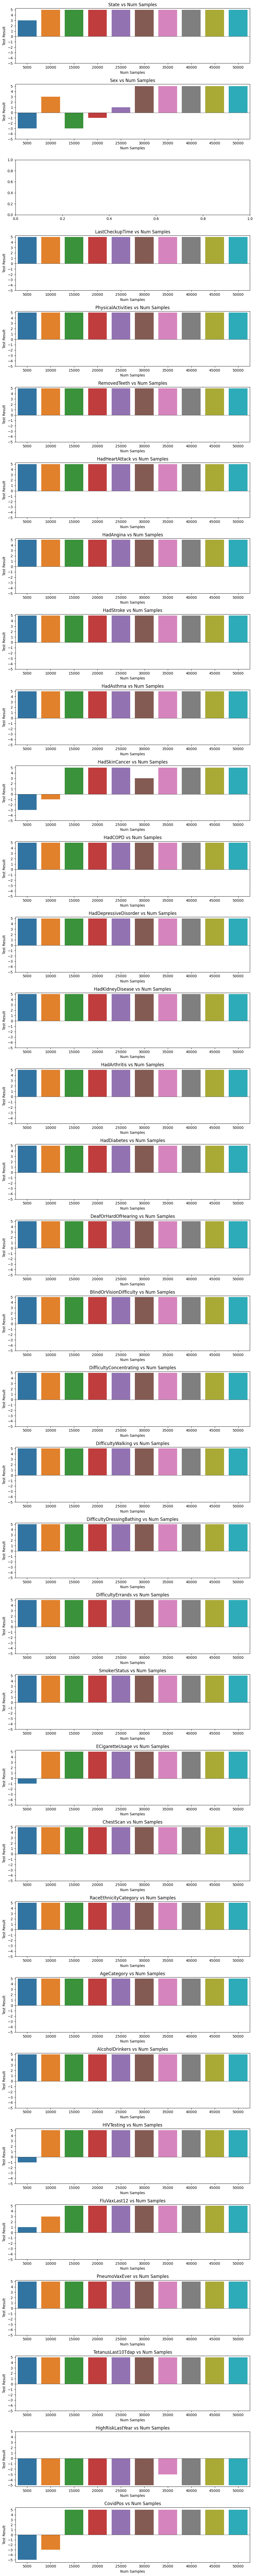

In [17]:
make_experiment_plots("random_sampling",5000,50001,5000)   

### Sample Size : 500 to 5000 ###

In [18]:
create_files("random_sampling",500,5001,500)

Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-500 done
Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-1000 done
Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-1500 done
Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-2000 done
Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-2500 done
Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-3000 done
Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-3500 done
Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-4000 done
Iteration-1 done
Iteration-2 done
Iteration-3 done
Iteration-4 done
Iteration-5 done
Sample Size-4500 done
Iteration-1 done
Iteration-2 done
Iter

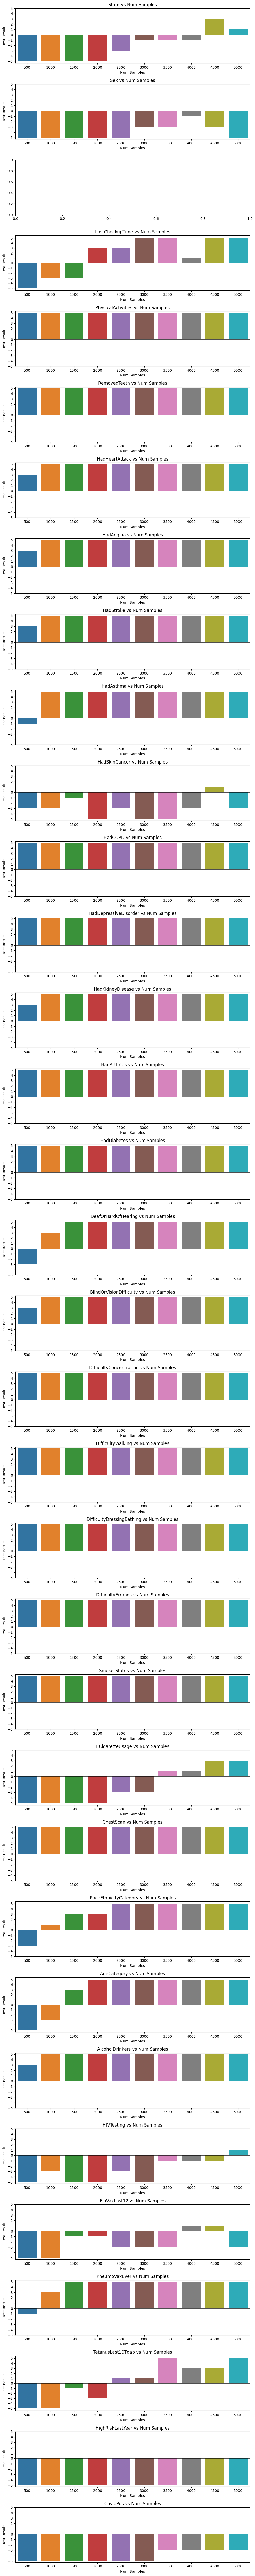

In [19]:
make_experiment_plots("random_sampling",500,5001,500)   